## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [53]:
import sys
import os

import torch
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from tifffile import imread, imwrite
from pathlib import Path
# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae
from monai.transforms import (
    Compose,
    NormalizeIntensity,
    RandSpatialCropSamples,
    CastToType,
    EnsureType,
    EnsureChannelFirst,
    RandFlip,
    Resize
)
from skimage import color
from utils import LoadTiff, Gray2RGB


### Define utils

In [71]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def show_image(image, title=""):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis("off")
    return


def prepare_model(chkpt_dir, arch="mae_vit_base_patch16"):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location="cpu")
    msg = model.load_state_dict(checkpoint["model"], strict=False)
    print(msg)
    return model


def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum("nhwc->nchw", x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    print(f"y shape: {y.shape}, mask shape: {mask.shape}")
    y = model.unpatchify(y)
    y = torch.einsum("nchw->nhwc", y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(
        1, 1, model.patch_embed.patch_size[0] ** 2 * 3
    )  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum("nchw->nhwc", mask).detach().cpu()

    x = torch.einsum("nchw->nhwc", x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams["figure.figsize"] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    print(im_masked[0].shape)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    y_gray = color.rgb2gray(y[0])
    y_gray = np.expand_dims(y_gray, axis=-1).repeat(3, axis=-1)
    show_image(torch.from_numpy(y_gray), "MAE reconstruction")

    plt.subplot(1, 4, 4)
    im_paste_gray = color.rgb2gray(im_paste[0])
    im_paste_gray = np.expand_dims(im_paste_gray, axis=-1).repeat(3, axis=-1)
    show_image(torch.from_numpy(im_paste_gray), "reconstruction + visible")

    plt.show()

### Load an image

torch.float32 torch.Size([224, 224, 3])


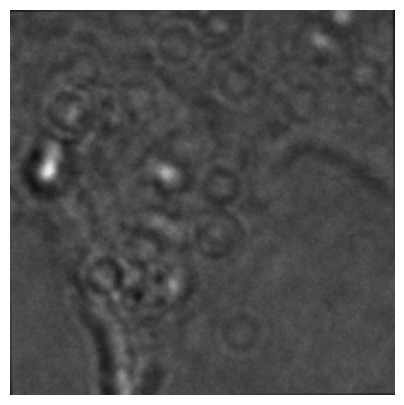

In [81]:
# # load an image
# img_url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"  # fox, from ILSVRC2012_val_00046145
# # img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img = Image.open(requests.get(img_url, stream=True).raw)
# img = img.resize((224, 224))
# img = np.array(img) / 255.0

# assert img.shape == (224, 224, 3)

# # normalize by ImageNet mean and std
# img = img - imagenet_mean
# img = img / imagenet_std
bf_path = Path(
    "/mnt/eternus/users/Justin/projects/16_isbi_challenge/v1/data/train/mitochondria/image_658_BF_z1_IM.tiff"
)
dic_path = Path(
    "/mnt/eternus/users/Justin/projects/16_isbi_challenge/v1/data/train/mitochondria/image_253_DIC_z8_IM.tiff"
)
pc_path = Path(
    "/mnt/eternus/users/Justin/projects/16_isbi_challenge/v1/data/train/mitochondria/image_2411_PC_z8_IM.tiff"
)
transform = Compose(
    [
        LoadTiff(),
        CastToType(dtype=np.float32),
        Gray2RGB(),
        EnsureType(),  # to tensor
        # Resize((224, 224), mode="bilinear", align_corners=False, anti_aliasing=True),
        transforms.ToPILImage(),
        transforms.Resize(224, interpolation=3),  # 3 is bicubic
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
bf_img = transform(bf_path)
bf_img = torch.einsum("chw->hwc", bf_img)
print(bf_img.dtype, bf_img.shape)
imwrite("test.tiff", bf_img.numpy())
plt.rcParams["figure.figsize"] = [5, 5]
show_image(bf_img)

torch.float32 torch.Size([224, 224, 3])


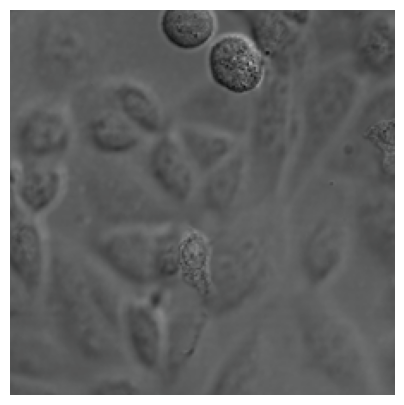

In [78]:
dic_img = transform(dic_path)
dic_img = torch.einsum("chw->hwc", dic_img)
print(dic_img.dtype, dic_img.shape)
imwrite("test.tiff", dic_img.numpy())
plt.rcParams["figure.figsize"] = [5, 5]
show_image(dic_img)

torch.float32 torch.Size([224, 224, 3])


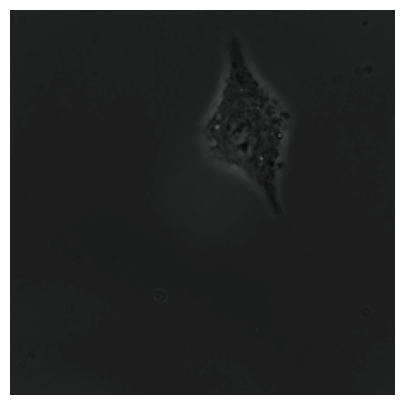

In [82]:
pc_img = transform(pc_path)
pc_img = torch.einsum("chw->hwc", pc_img)
print(pc_img.dtype, pc_img.shape)
imwrite("test.tiff", pc_img.numpy())
plt.rcParams["figure.figsize"] = [5, 5]
show_image(pc_img)

### Load a pre-trained MAE model

In [57]:
chkpt_dir = "/mnt/eternus/users/Yu/project/LightMyCells/exp/exp13/checkpoint-399.pth"
model_mae = prepare_model(chkpt_dir, "mae_vit_base_patch16")
print("Model loaded.")

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


/tmp/ipykernel_1852456/3272980445.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


y shape: torch.Size([1, 196, 768]), mask shape: torch.Size([1, 196])
torch.Size([224, 224, 3])


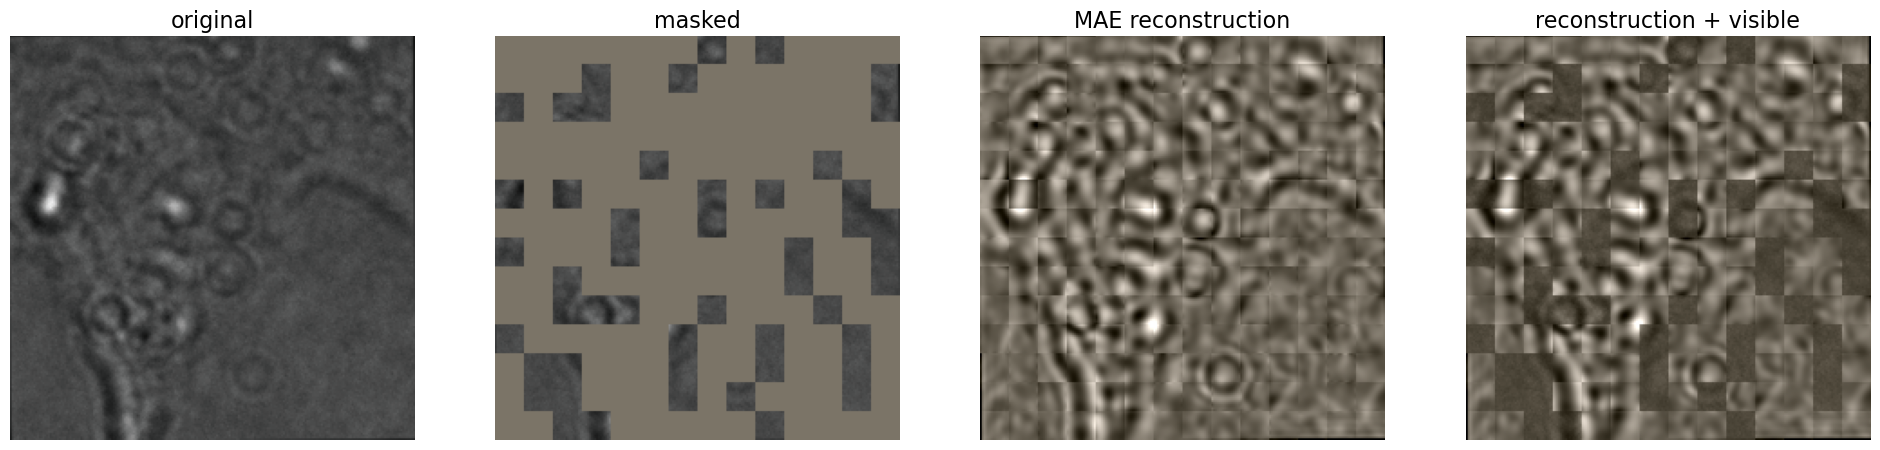

In [72]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print("MAE with pixel reconstruction:")
run_one_image(bf_img, model_mae)

MAE with pixel reconstruction:


/tmp/ipykernel_1852456/3272980445.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


y shape: torch.Size([1, 196, 768]), mask shape: torch.Size([1, 196])
torch.Size([224, 224, 3])


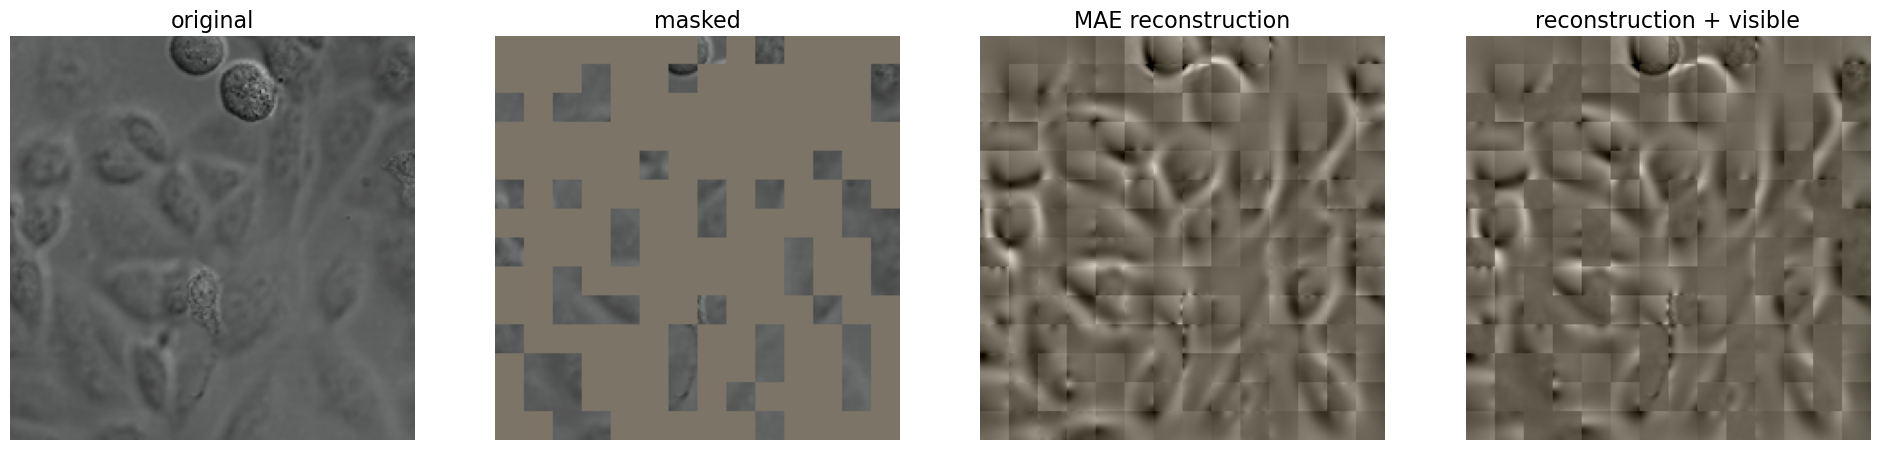

In [79]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print("MAE with pixel reconstruction:")
run_one_image(dic_img, model_mae)

MAE with pixel reconstruction:


/tmp/ipykernel_1852456/3272980445.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


y shape: torch.Size([1, 196, 768]), mask shape: torch.Size([1, 196])
torch.Size([224, 224, 3])


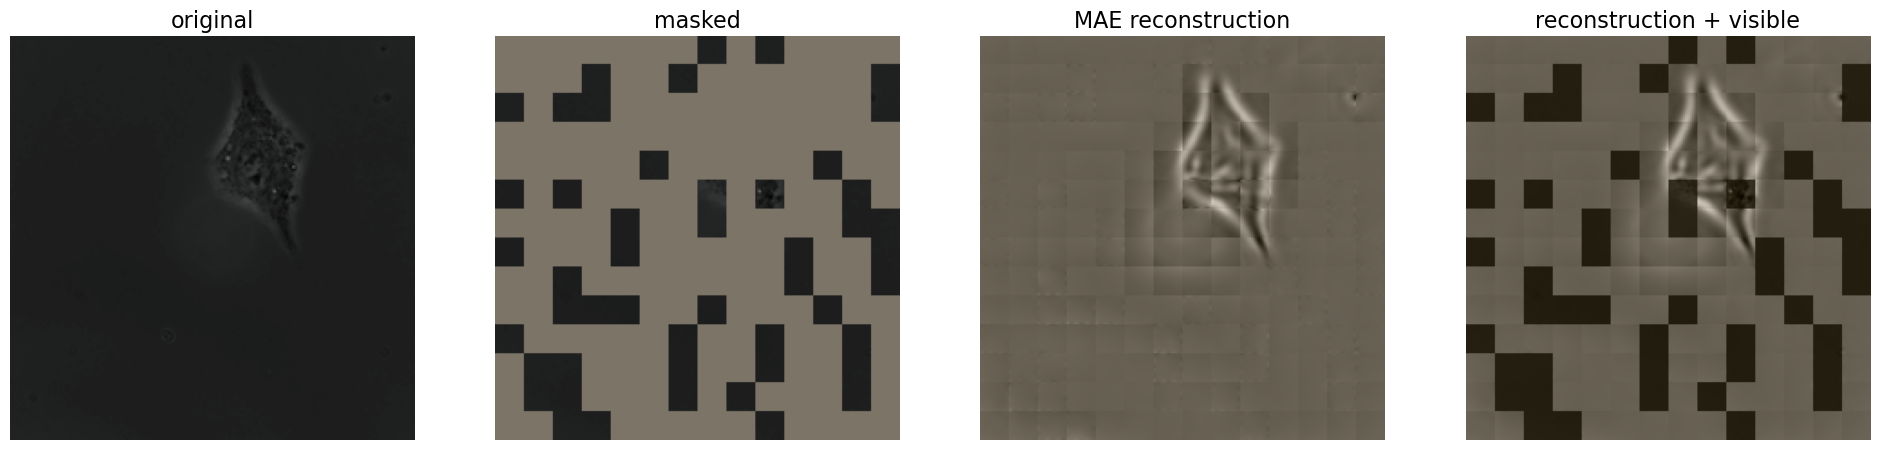

In [83]:
torch.manual_seed(2)
print("MAE with pixel reconstruction:")
run_one_image(pc_img, model_mae)

### Load another pre-trained MAE model

In [6]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


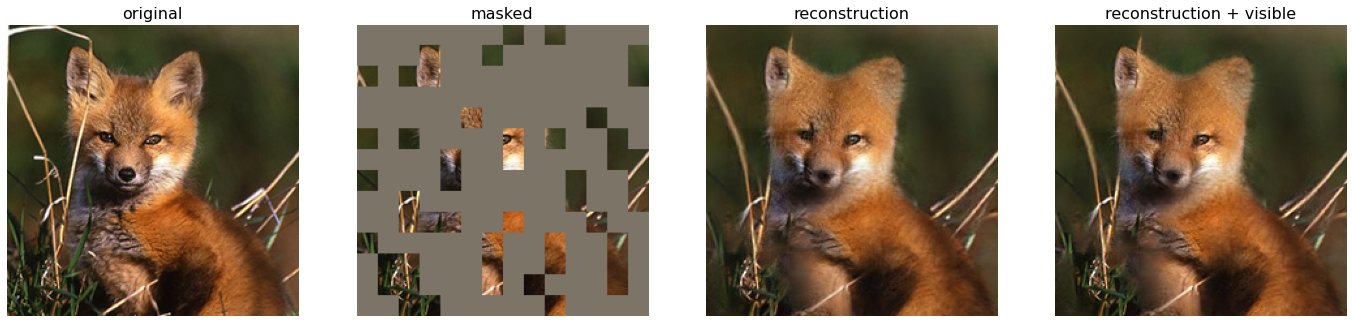

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print("MAE with extra GAN loss:")
run_one_image(img, model_mae_gan)